# Computer Science 358: Independent Research / Machine Learning for Meteorology
_Rachel Frantsen '16, Dr. Matthew Richey_

The following program is the result of experimentation with the application of machine learning (ML) techniques to meteorological radar. Currently, numerical weather prediction (NWP) is the dominant technique for predicting weather patterns, employing mathematical models based on fluid dynamics and thermodynamics. Investigations into meteorological applications of ML have been few and far between, due to ML's recent emergence as a potentially useful tool.

Current NWP models are effective thanks to decades of development when there was no feasible alternative, and ML approaches may need the same attention and development in order to become competitively useful - however we will never know unless we take the time to develop the techniques.

This independent research seeks to investigate the potential of ML techniques in meteorological applications and develop a framework for asking questions about its effectiveness.

## Receiving data from NOAA

I tried out several sources of weather data and techniques for fetching them - including Weather Underground, the National Oceanic and Atmospheric Administration's (NOAA) Climate Data archives, and the NOAA radar system. Wunderground provided a convenient API for accessing weather information such as temperature and rainfall amount at particular observation sites, but it was more difficult to recieve radar. The Climate Data archives provided a large amount of data in bulk, but it was inconvenient to obtain and to parse. My work with NOAA radar was most productive so that is what is used in this demonstration.

In order to retrieve the data, I set up a scheduled job using Cron on a lab computer to run the following script every three hours, since it took about three hours on average to run the script each time and there was about only about four recent hours of data available online at a time.

As evident in the script, I pulled six typs of radar from 16 radar stations from the inland United States, varying the time between each download in order to limit the load on the NOAA servers, and then logged the time the download was completed. At the time of my writing this, there had been a total of 481 full downloads. 

_After recieving data from NOAA onto RNS 202-20, I loaded them onto my local machine to use on the Jupyter Ipython 3.6 server that I set up there, using an rsync command._

In [138]:
import os, sys
from PIL import Image
import numpy as np
import pandas as pd
from IPython import display
%matplotlib inline
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt
import random

## Converting images to data

The following cell is a function (translate_n0r) that converts a N0R or N0S radar image to a list of dBZ values.

> "dBZ" stands for decibels relative to _Z_, a factor of reflectivity relative to that of a 1 mm drop of rain. The abbreviation can be thought of simply as _reflectivity_, and it directly corresponds to a specific intensity in precipitation. For example, 10 dBZ directly corresponds to light mist, and 50 dBZ corresponds to heavy rain.

The function gets RGB values from the palette of the GIF-formatted radar image, then uses a dictionary to translate the RGB values into single dBZ data points.

In [2]:
def translate_n0r(img, palette):
    standardizedImg = []
    known_colors = {(0, 142, 0): 30,
     (1, 159, 244): 10,
     (1, 197, 1): 25,
     (2, 253, 2): 20,
     (3, 0, 244): 15,
     (4, 233, 231): 5,
     (152, 84, 198): 70,
     (212, 0, 0): 55,
     (229, 188, 0): 40,
     (248, 0, 253): 65,
     (253, 0, 0): 50,
     (253, 149, 0): 45,
     (253, 248, 2): 35,
     (253, 253, 253): 75}
    for j in range(len(img)):
        colorNum = img[j]
        r,g,b = palette[colorNum*3+0], palette[colorNum*3+1], palette[colorNum*3+2]
        if (r,g,b) in known_colors:
            standardizedImg.append(known_colors[(r,g,b)])
        else:
            standardizedImg.append(0)
    return standardizedImg         

## Pulling data from the file system

The following function reads in files from my local radar repository and outputs two multidimensional Python arrays - one which is the input data for training, and one which is the predicted result for that data. There are multiple rows in each, depending on the "num_samples" paramter. Along the way, we resize each image, in order to reduce the number of pixels we must create models for.

Note that while our objective is to train ML models, one for each pixel, I am using the entire image to train each pixel. The hope is that the motion of the weather nearby will contribute to the prediction of each individual spot. This is an attempt to avoid the problems that I ran into when trying to predict temperature data by using data from only one observation station.

In [123]:
def import_data(locations, radar_type, sample_size, num_samples_initial, frame_delay=0, dimension=20):
    X_output = []  
    to_Y = []
    for location in locations:
        cur_path = "../radar_archive/radar.weather.gov/ridge/RadarImg/"+radar_type+"/"+location
        all_files = os.listdir(cur_path)[1:]
        num_samples = min(num_samples_initial, len(all_files)-sample_size-frame_delay-1)
        for i in range(num_samples):
            files_subset = all_files[i:sample_size+i+frame_delay+1]
            to_output = []
            for filename in files_subset:
                infileName = cur_path+"/"+filename
                outfileName = cur_path+"/small/"+filename
                im = Image.open(infileName)
                im = im.resize((dimension,dimension))
                to_output.extend(translate_n0r(list(im.getdata()), im.getpalette()))
                im.save(outfileName, "gif")
            to_Y.append(to_output[-dimension**2:])
            X_output.append(to_output[:-((dimension**2)*(1+frame_delay))])
    
    # Rotate Y data
    Y_output = []  
    for i in range(dimension**2):
        short_Y = []
        for j in range(num_samples*len(locations)):
            short_Y.append(to_Y[j][i])
        Y_output.append(short_Y)
    
    return X_output, Y_output

In [133]:
to_dataframe, Y_file_vals = import_data(["BIS", "TWX", "EAX"], "N0R", 30, 2)

Here I transformed the data into a Pandas dataframe so that it would be compatible with Scikit-Learn.

In [93]:
# Create labels for the data
df_columns = []
for i in range(30):
    for j in range(20):
        for k in range(20):
            df_columns.append(str(i)+":"+str(j+1)+","+str(k+1))
            
# Convert to Pandas dataframe
df = pd.DataFrame(to_dataframe, columns=df_columns)
df = df._get_numeric_data()
df.head(10)

,"0:1,1","0:1,2","0:1,3","0:1,4","0:1,5","0:1,6","0:1,7","0:1,8","0:1,9","0:1,10",...,"29:20,11","29:20,12","29:20,13","29:20,14","29:20,15","29:20,16","29:20,17","29:20,18","29:20,19","29:20,20"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Making the prediction

Here I created an array of models, and each model represents one pixel in an image. Again for each row of the table I am using an array of data from whole images, in this case 30 images, to predict each single pixel.

**WARNING: This cell may take a VERY long time to run!**

In [94]:
pixel_models = []
for i in range(20**2):
    Y_train_pixel = pd.DataFrame(Y_file_vals[i])
    pixel_models.append(Lasso(alpha=100).fit(df, Y_train_pixel))

In [95]:
X_test, Y_test = import_data(["ILX"], "N0R", 30, 1)
df_test = pd.DataFrame(X_test, columns=df_columns)
df_test = df_test._get_numeric_data()
df_test

,"0:1,1","0:1,2","0:1,3","0:1,4","0:1,5","0:1,6","0:1,7","0:1,8","0:1,9","0:1,10",...,"29:20,11","29:20,12","29:20,13","29:20,14","29:20,15","29:20,16","29:20,17","29:20,18","29:20,19","29:20,20"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
predicted_radar = []
for i in range(20**2):
    predicted_pixel_Y = pixel_models[i].predict(df)
    predicted_radar.append(int(predicted_pixel_Y[0]))

## Turning predicted data back into an image

The function save_predicted turns the predicted data into an easily understood visual format, a GIF file just like all the input data. It does this by mapping each predicted value onto a tuple that represents an RGB value, and then saves it as a new image in a designated folder.

In [97]:
def save_predicted(predicted_values, d, newfilename):
    n0r_to_color = {5: (4, 233, 231, 1),
     10: (1, 159, 244, 1),
     15: (3, 0, 244, 1),
     20: (2, 253, 2, 1),
     25: (1, 197, 1, 1),
     30: (0, 142, 0, 1),
     35: (253, 248, 2, 1),
     40: (229, 188, 0, 1),
     45: (253, 149, 0, 1),
     50: (253, 0, 0, 1),
     55: (212, 0, 0, 1),
     65: (248, 0, 253, 1),
     70: (152, 84, 198, 1),
     75: (253, 253, 253, 1),
     0: (0,0,0,0)}
    rgba_image_array = []
    for value in predicted_values:
        rgba_image_array.append(n0r_to_color[value-value%5])
    img = Image.new("RGBA", (d, d), color = (0,0,0,0))
    img.putdata(rgba_image_array)
    img.save(newfilename, transparent = 0)

In [98]:
predicted_filenames = ["N0R_ILX_1"]
predicted_filepaths = []
for predicted_filename in predicted_filenames:
    predicted_filepath = "../radar_predicted/" + predicted_filename + ".gif"
    predicted_filepaths += [predicted_filepath]
    save_predicted(predicted_radar, 20, predicted_filepath)

## Image example

Here I've compared a predicted image, using models trained over four iterations, with the actual image corresponding with the test dataset, for purposes of illustration.

In [100]:
displayMarkup = 'Predicted {} at {}: <img src="{}" width=50% height=50% style="image-rendering:pixelated">'.format("N0R", "ILX", predicted_filepaths[0])
Y_test_filepath = "../radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ILX/small/" + os.listdir("../radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ILX")[30]
displayMarkup += '<br>Actual {} at {}: <img src="{}" width=50% height=50% style="image-rendering:pixelated">'.format("N0R", "ILX", Y_test_filepath)
display.HTML(displayMarkup)

# Measuring accuracy

To create a measure of accuracy the following function calculates both Mean Squared Error (MSE) and Euclidian Error. (In the first few "proof of concept" cells, we examine both MSE and Euclidian Error, but for use in practice we use exclusively Euclidian Error.)

It is worth mentioning that the error rates are calculated by the difference of dBZ values at original(x,y) and predicted(x,y). I.e., different values at the same location. This could prove problematic when the prediction is pretty close, but perhaps one pixel is off by a column or row. In this case, the difference would be counted twice - once for being missing from the correct spot, and once for being present in an incorrect spot. Visualize with me an extreme case of this - the expected result is a checkerboard with an even number of columns, but the predicted result is the same checkerboard flipped across the Y axis. At first glance the prediction looks very impressive, and in fact it is in the overall scheme. However because of the specificities of the error calculation method this case would yield a very high error rate.

In [101]:
def mse_euclidian_error(predicted, calculated):
    from math import sqrt
    squared_total_vals = 0.0
    length = len(calculated)
    for i in range(length):
        squared_total_vals += (predicted[i] - calculated[i])**2
    mse = squared_total_vals/length
    euclidian_distance = sqrt(squared_total_vals)/length
    return mse, euclidian_distance

Finding the MSE and Euclidian Error rates of the last (visual) example - the predicted frame versus the actual next frame.

In [128]:
im = Image.open(Y_test_filepath)
Y_file_vals = translate_n0r(list(im.getdata()), im.getpalette())
print(mse_euclidian_error(Y_file_vals, predicted_radar))

(5.285, 0.11494563932572649)


Below: the error rate of the "null case" - the error rate of the frame to be predicted as compared to the frame directly before it (used in the training set). It is evident that the prediction model is doing a better job than predicting a frame that is exactly the same as the previous one. This is the result we hoped for!

In [132]:
previous_Y_filepath = "../radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ILX/small/" + os.listdir("../radar_archive/radar.weather.gov/ridge/RadarImg/N0R/ILX")[29]
im_prev = Image.open(previous_Y_filepath)
Y_prev_vals = translate_n0r(list(im_prev.getdata()), im_prev.getpalette())
mse2, euc2 = mse_euclidian_error(Y_file_vals, Y_prev_vals)
print(mse2, euc2)


26.0 0.25495097567963926


The lowest error rate can be seen below, demonstrated as a comparison between two identical arrays.

In [103]:
print(mse_euclidian_error(Y_file_vals, Y_file_vals))

(0.0, 0.0)


Below: a high error rate generated by comparing two randomly-generated arrays of the same size as our 20-by-20 scaled-down radar images.

In [104]:
random_1 = []
random_2 = []
for i in range(400):
    random_1.append(random.randrange(0,76))
    random_2.append(random.randrange(0,76))
print(mse_euclidian_error(random_1, random_2))

(936.9275, 1.5304635735619454)


## Comparing results of different training set sizes

The function error_from_num_iterations is all the code we have demonstrated so far collected to return an error rate. The parameter num_iterations specifies the number of rows from each of the stations MPX, DMX, ABR, OAX, and ILX to use in model training. The example below compares the accuracy of five total rows versus ten. It is a small amount, but I felt that I would need greater computing power to be able to scale this very much further.

**WARNING: THE SECOND CELL FOLLOWING ALWAYS AN TAKES EXTREMELY LONG TIME TO RUN**

In [139]:
def error_from_num_iterations_and_delay(num_iterations, saveas, delay=0, model=0):
    to_dataframe, Y_file_vals = import_data(["BIS", "DMX", "DVN", "EAX", "TWX"], "N0R", 30, num_iterations, frame_delay = delay)

    # Create labels for the data
    df_columns = []
    for i in range(30):
        for j in range(20):
            for k in range(20):
                df_columns.append(str(i)+":"+str(j+1)+","+str(k+1))

    # Convert to Pandas dataframe
    df = pd.DataFrame(to_dataframe, columns=df_columns)
    df = df._get_numeric_data()

    # Train pixel models
    pixel_models = []
    for i in range(20**2):
        Y_train_pixel = pd.DataFrame(Y_file_vals[i])
        if model == 0:
            pixel_models.append(Lasso(alpha=100).fit(df, Y_train_pixel))
        elif model == 1:
            pixel_models.append(Ridge(alpha=100).fit(df, Y_train_pixel))

    X_test, Y_test = import_data(["ILX"], "N0R", 30, 1)
    df_test = pd.DataFrame(X_test, columns=df_columns)
    df_test = df_test._get_numeric_data()

    predicted_radar = []
    for i in range(20**2):
        predicted_pixel_Y = pixel_models[i].predict(df)
        predicted_radar.append(int(predicted_pixel_Y[0]))

    predicted_filepath = "../radar_predicted/" + saveas + ".gif"
    save_predicted(predicted_radar, 20, predicted_filepath)

    im = Image.open(Y_test_filepath)
    Y_file_vals = translate_n0r(list(im.getdata()), im.getpalette())
    mse, euc = mse_euclidian_error(Y_file_vals, predicted_radar)
    return euc

In [106]:
error_by_iterations = []
# Warning: the number of rows you enter as the range will be multiplied by 5! 1 is not a small difference!
for i in [1, 2, 4, 6]:
    ls = []
    ls.append(i)
    filename = "N0R_ILX_bulk_" + str(i)
    ls.append(error_from_num_iterations_and_delay(i, filename, 0))
    error_by_iterations.append(ls)

In [107]:
error_by_iterations

[[1, 0.10479145957567343],
 [2, 0.10550473923004595],
 [4, 0.09575359001102779],
 [6, 0.09585144756340407]]

## Visualizaton of error rates

According to the visualization below, it is easy to see that the error rates of the prediction are decreasing (overall) even over elementary increases to the size of the training set. With even more computing power we would be able to see a greater increase in accuracy. Here we increase the training set from 5, to 10, to 15, to 20, since the set of training material consists of five stations and we increase the number of samples of each by 1.

In this case, the number of samples, or "iteration number", uses the same 5 stations as in previous examples, but also a number of sets "shifted over" by one. It is simply a convenient way to increase the size of the set of training data. So if we have frames 1,2,3,4,5,6 for each station, specifying an iteration number of 3 would give {x}{y} training sets of {1,2,3}{4}, {2,3,4}{5}, {3,4,5},{6}. You can see this code in action in the function under "Pulling data from the file system".

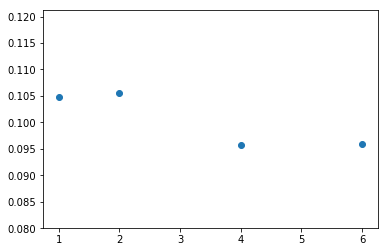

In [108]:
plot_x = []
plot_y = []
for i in range(len(error_by_iterations)):
    plot_x.append(error_by_iterations[i][0])
    plot_y.append(error_by_iterations[i][1])
        
plot_x = np.array(plot_x)
plot_y = np.array(plot_y)
plt.scatter(plot_x, plot_y)

## Error over different prediction intervals

The following code tries different "delay" values - or the number of frames in the future to predict. By this I mean if we have frames 1,2,3,4,5,6,7,8 to work with and we always train on 1,2,3,4, a delay of 1 would mean we train our models to predict frame 5, a delay of 2 would mean we're trying to predict frame 6, etc. Since there are anywhere between 10-12 frames recorded per hour and roughly 5 minutes between each frame, a delay of 10 frames is about equivalent to an hour. So I've tested the accuracy of our model (using 5 training iterations) over prediction intervals of 0, about 10 minutes, 20 minutes, 30 minutes... up to an hour.

Below you can also see this increase plotted on a graph to visualize the rate at which the accuracy decreases with further intervals. The data varies, but there is a clear _overall_ downward trend, and it seems not to be very steep - the difference. Here, the difference between predicting the next frame has a similar error rate to predicting the state of precipitation in 45 minutes.

**WARNING: THE FOLLOWING CELL TAKES AN EXTREMELY LONG TIME TO RUN**

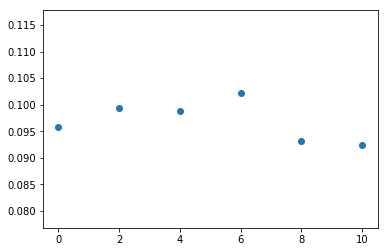

In [125]:
error_by_distance_in_future = []
# Warning: the number of rows you enter as the range will be multiplied by 5! 1 is not a small difference!
for i in [0,2,4,6,8,10]:
    ls = []
    ls.append(i)
    filename = "N0R_ILX_delay_" + str(i)
    ls.append(error_from_num_iterations_and_delay(4, filename, i)) # 20 rows of training data for each test sample
    error_by_distance_in_future.append(ls)
error_by_distance_in_future

plot2_x = []
plot2_y = []
for i in range(len(error_by_distance_in_future)):
    plot2_x.append(error_by_distance_in_future[i][0])
    plot2_y.append(error_by_distance_in_future[i][1])
        
plot2_x = np.array(plot2_x)
plot2_y = np.array(plot2_y)
plt.scatter(plot2_x, plot2_y)

### Effectiveness of other predicive models

In the following cell we try ridge regression using the same training/test data as in the visual (first) example. There is an even better error rate using ridge regression than we got using lasso (~0.115...)!

In [140]:
print(error_from_num_iterations_and_delay(i, "N0R_ILX_ridge_", 0, model = 1))

0.10350120772242226


# Conclusion and future work

Over the course of this project I found that larger training sizes actually did improve the predictive ability of the model we used, and the decrease in accuracy over larger prediction intervals was not as steep of a curve as I expected to see!

The main constraint on this research effort was the very same issue that hampers NWP prediction techniques at large scale - the availability of computing power. Moving to an Amazon Web Service (AWS) virtual machine may be an open door to experiment with exactly that. Currently, this notebook is operating on a Micro T2 instance of Elastic Cloud 2, which provides 1 virtual CPU and 1 GB of memory. Detaching the storage volume from this instance and reattaching it to a more powerful one, if we choose to exceed the free account teir, would be fairly straightforward. Future efforts might include an increase of computing power, as well as parallel and distributed techniques, to extend the capability of meteorological ML applications.